# DRL Exercise 2: Policy Gradient Methods


Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

In this assignment, we will optimize the policy of the agent directly with policy gradient methods.

First, we will implement the basic REINFORCE algorithm. Then, we will transform it into an Actor-Critic algorithm.

## Section 1: Monte-Carlo Policy Gradient (REINFORCE)

Policy gradient methods try to directly optimize the policy $π(a|s;θ)$. They use a probability distribution over actions parameterized by θ, expressing the probability to take an action *a* in state *s*.

An example of such a distribution is the softmax distribution:

$π(a|s;θ) = \frac{exp(θ_i)}{∑_j exp(θ_j)}$

REINFORCE is a basic policy gradient method that updates θ each iteration by taking a step in the direction of $E_t[∇logπ_θ(a_t|s_t)R_t]$.

REINFORCE with baseline is a common way to reduce the variance of the model, where the baseline is subtracted from the return to form the advantage estimate: $A_t = R_t - b(s_t)$. We use the advantage in the computation of the gradient instead of the return. A common choice for the baseline is the value function $V^π(s_t)$.

**What does the value of the advantage estimate reflect? Why is it better to follow the gradient computed with the advantage estimate instead of just the return?**

We use the value of the advantage estimate, $ Â_t = R_t - b(s_t)$ to see how much better or worse an action $a_t$ performed in state $s_t$ is as compared to the expected return. This rewards actions that outperform the average, and if all of the actions are good choices, then the action chosen doesn’t have a large effect on the result.

It is better to follow the gradient computed using the $Â_t$ instead of just the return itself because it reduces the variance of the updates. The REINFORCE without the baseline (just the return) algorithm can be slow to converge and have high fluctuations. Using the advantage estimate reduces the size of the update, and it is not correlated with the action $a_t$. By centering the return around the expected value, the advantage estimate reduces the variance of the policy gradient estimates.

**The reduction of the baseline does not introduce bias to the expectation of the gradient since: $E_π[∇logπ_θ(a_t|s_t)b(s_t)] = 0$. What is the prerequisite condition for this to be true?**

* Recall the derivative property: $\frac{d}{dx}log(y(x))=\frac{1}{y(x)}\frac{d}{dx}y(x)$, which in our case with regards to the gradient will give us: $∇logπ(a|s)=\frac{∇π(a|s)}{π(a|s)}$, which in turn gives us: $π(a|s)∇logπ(a|s)=∇π(a|s)$.

* In addition, recall the definition of the expectation under a probability distribution is $E_π[∇logπ(a_t|s_t)b(s_t)]=∫π(a_t|s_t)∇logπ(a_t|s_t)b(s_t)da_t$.

* If we substitute the value we found in the first part into the integral, we get: $\intπ(a_t|s_t)∇logπ(a_t|s_t)b(s_t)da_t=\int∇π(a|s)b(s_t)da_t$.

* If we assume that the baseline is *only* dependent on the state and not on the action, then we can take it out of the integral: $\int∇π(a|s)b(s_t)da_t=b(s_t)\int∇π(a|s)da_t$

* According to the rules of probabilities, the sum over all probabilities in a distribution must equal 1, which means that $∫π(a|s)da_t=1$. If we take the gradient of both sides: $∇∫π(a|s)da_t=∇1$, we get that $\int∇π(a|s)da_t=∇∫π(a|s)da_t=0$.

* The first transition is possible by the Leibniz Rule: $\frac{d}{dθ}\int\limits_{a(θ)}^{b(θ)}f(x,θ)dx=f(b(θ),\theta)\frac{d}{dθ}b(\theta)-f(a(θ),θ)\frac{d}{dθ}a(θ)+\int\limits_{a(θ)}^{b(θ)}\frac{d}{d\theta}f(x,\theta)dx$.
Since the limits of the integral are not dependent on any parameter, and simply cover the entire probability space, the first two terms disappear, leaving us with: $\frac{d}{dθ}\int\limits_{a(θ)}^{b(θ)}f(x,θ)dx=\int\limits_{a(θ)}^{b(θ)}\frac{d}{d\theta}f(x,\theta)dx$,
or in terms of our problem: $∇\intπ(a|s)da_t=\int∇π(a|s)da_t$.

* Therefore, we have found that: $E_π[∇logπ_θ(a_t|s_t)b(s_t)] = 0$ if the baseline function is not dependent on the action, only on the state. This is the prerequisite condition for this equation to be true.

We will write two versions of the REINFORCE algorithm - one is the basic version of the algorithm, and the second is REINFORCE with baseline with a value function approximation as the baseline. The agent will be evaluated on the CartPole environment from OpenAI Gymnasium.

In [ ]:
!pip install gymnasium
!pip install torch torchvision

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# average reward over 100 episodes tracking
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards):
    target_average = 475.0

    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        episodes_to_target = episode + 1
        print(f"Agent reached optimal performance with an average reward of {target_average} over 100 episodes at episode {episodes_to_target}")

    return rolling_avg

### REINFORCE Algorithm

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
def reinforce(env, policy_network, optimizer, num_episodes=1000, gamma=0.99, convergence_window=100, convergence_threshold=195,
              optimal_performance_threshold=475):
    policy_network.train()
    rewards_per_episode = []
    rolling_avg_rewards = []
    losses = []
    convergence = False

    for episode in range(num_episodes):
        state = env.reset()
        rewards = []
        log_probs = []

        done = False
        while not done: # Monte-Carlo algorithm
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy_network(state_tensor) # policy network outputs the action probabilities
            action_dist = torch.distributions.Categorical(action_probs) # create probability distribution for actions
            action = action_dist.sample() # sample action from the distribution
            log_probs.append(action_dist.log_prob(action))

            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)

        # calculate Gt
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        # update
        returns = torch.tensor(returns, dtype=torch.float32)
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_loss.append(-log_prob * Gt)

        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum() # negative log likelihood loss = gradient ascent
        policy_loss.backward()
        optimizer.step()

        losses.append(policy_loss.item())
        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    return rewards_per_episode, losses, rolling_avg_rewards

### REINFORCE with Baseline

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
def reinforce_with_baseline(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=1000, gamma=0.99,
                            convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    for episode in range(num_episodes):
        state = env.reset()
        rewards = []
        log_probs = []
        values = []

        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy_network(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_probs.append(action_dist.log_prob(action))

            value = value_network(state_tensor)
            values.append(value)

            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)

        # calculate Gt
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        # update
        returns = torch.tensor(returns, dtype=torch.float32)
        values = torch.stack(values).squeeze()
        advantages = returns - values.detach()

        policy_loss = []
        for log_prob, advantage in zip(log_probs, advantages):
            policy_loss.append(-log_prob * advantage)

        policy_optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum() # negative log likelihood loss = gradient ascent
        policy_loss.backward()
        policy_optimizer.step()

        # update value network
        value_loss = nn.functional.mse_loss(values, returns)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        policy_losses.append(policy_loss.item())
        value_losses.append(value_loss.item())

        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards


### Run

We decided to look at two different metrics to measure the performance of the algorithms. First, we defined the convergence of the algorithm to be when for the past 100 episodes, it reaches a rolling average over the past 100 episodes of 195 or above. We decided on this threshold because this is a “good enough” result, meaning that the algorithm is consistently performing well, if not optimally. Secondly, we decided on an optimal performance threshold of a rolling average of 475, which indicates that the algorithm has reached a state where it is mostly getting perfect scores in the game.

In [ ]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
alpha = 1e-3

policy_net = PolicyNetwork(state_dim, action_dim)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

print("Running Basic REINFORCE...")
rewards_per_episode, losses, rolling_avg_rewards = reinforce(env, policy_net, policy_optimizer, num_episodes=2000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Running Basic REINFORCE...
Episode 1, Episode Reward: 13.0, Rolling Avg Reward: 13.0
Episode 2, Episode Reward: 11.0, Rolling Avg Reward: 12.0
Episode 3, Episode Reward: 17.0, Rolling Avg Reward: 13.666666666666666
Episode 4, Episode Reward: 19.0, Rolling Avg Reward: 15.0
Episode 5, Episode Reward: 10.0, Rolling Avg Reward: 14.0
Episode 6, Episode Reward: 12.0, Rolling Avg Reward: 13.666666666666666
Episode 7, Episode Reward: 27.0, Rolling Avg Reward: 15.571428571428571
Episode 8, Episode Reward: 21.0, Rolling Avg Reward: 16.25
Episode 9, Episode Reward: 11.0, Rolling Avg Reward: 15.666666666666666
Episode 10, Episode Reward: 35.0, Rolling Avg Reward: 17.6
Episode 11, Episode Reward: 17.0, Rolling Avg Reward: 17.545454545454547
Episode 12, Episode Reward: 48.0, Rolling Avg Reward: 20.083333333333332
Episode 13, Episode Reward: 12.0, Rolling Avg Reward: 19.46153846153846
Episode 14, Episode Reward: 19.0, Rolling Avg Reward: 19.428571428571427
Episode 15, Episode Reward: 31.0, Rolling Av

In the REINFORCE algorithm, we reached convergence on episode 487 and optimal performance on episode 857.

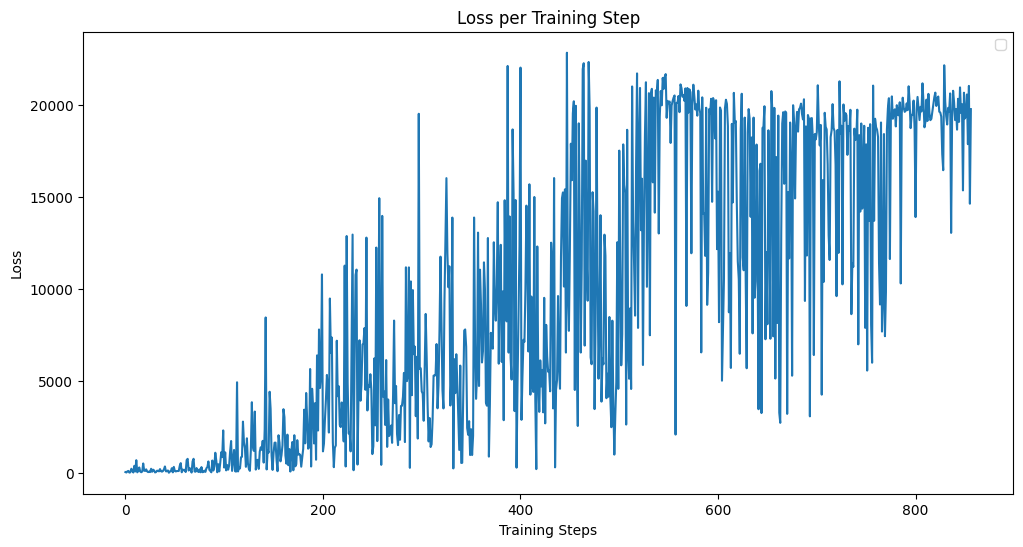

In [ ]:
# Plot: loss in each training step
plt.figure(figsize=(12, 6))
plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Loss per Training Step")
plt.legend()
plt.show()

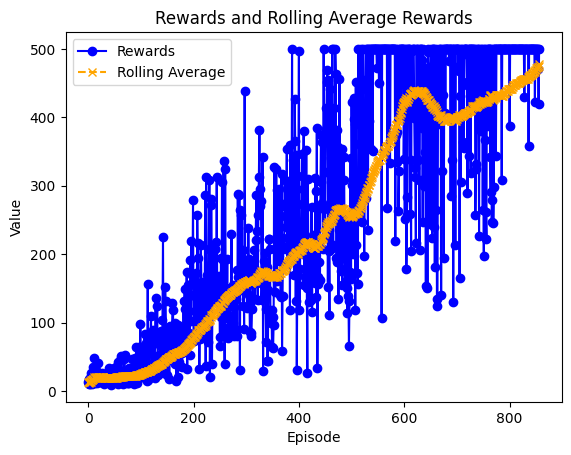

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title("Rewards and Rolling Average Rewards")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
value_net = ValueNetwork(state_dim)
value_optimizer = optim.Adam(value_net.parameters(), lr=1e-3)

policy_net_b = PolicyNetwork(state_dim, action_dim)
policy_optimizer_b = optim.Adam(policy_net_b.parameters(), lr=1e-3)

print("\nRunning REINFORCE with Baseline...")
rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards = reinforce_with_baseline(env, policy_net_b, value_net, policy_optimizer_b, value_optimizer, num_episodes=2000)


Running REINFORCE with Baseline...
Episode 1, Episode Reward: 20.0, Rolling Avg Reward: 20.0
Episode 2, Episode Reward: 23.0, Rolling Avg Reward: 21.5
Episode 3, Episode Reward: 16.0, Rolling Avg Reward: 19.666666666666668
Episode 4, Episode Reward: 24.0, Rolling Avg Reward: 20.75
Episode 5, Episode Reward: 17.0, Rolling Avg Reward: 20.0
Episode 6, Episode Reward: 17.0, Rolling Avg Reward: 19.5
Episode 7, Episode Reward: 11.0, Rolling Avg Reward: 18.285714285714285
Episode 8, Episode Reward: 15.0, Rolling Avg Reward: 17.875
Episode 9, Episode Reward: 33.0, Rolling Avg Reward: 19.555555555555557
Episode 10, Episode Reward: 12.0, Rolling Avg Reward: 18.8
Episode 11, Episode Reward: 29.0, Rolling Avg Reward: 19.727272727272727
Episode 12, Episode Reward: 13.0, Rolling Avg Reward: 19.166666666666668
Episode 13, Episode Reward: 17.0, Rolling Avg Reward: 19.0
Episode 14, Episode Reward: 15.0, Rolling Avg Reward: 18.714285714285715
Episode 15, Episode Reward: 19.0, Rolling Avg Reward: 18.733

In the REINFORCE with Baseline algorithm, we reached convergence on episode 392 and optimal performance on episode 686.

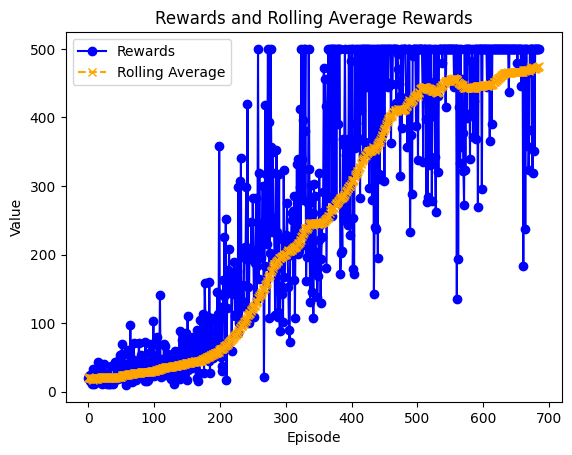

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title("Rewards and Rolling Average Rewards")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

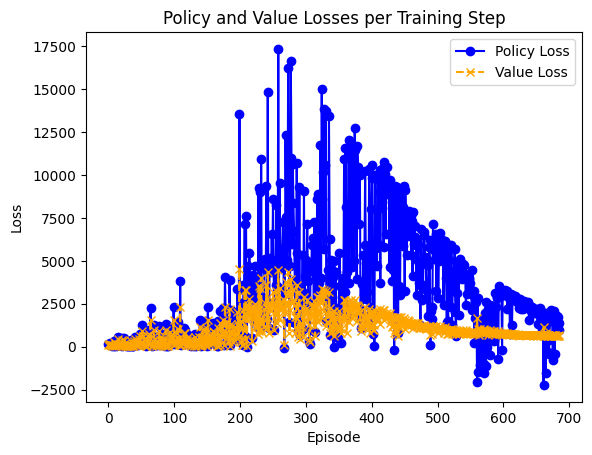

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title("Policy and Value Losses per Training Step")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Discussion

In general, we can see that both algorithms perform well, achieving both convergence and optimal performance within 1000 episodes. The graphs of the rewards for both algorithms look very similar with consistent (if not monotonic) trends upwards until optimal performance is reached. However, the REINFORCE with baseline algorithm reached convergence 95 episodes before the REINFORCE algorithm and optimal performance 171 episodes before the REINFORCE algorithm. We can see that including the value function as the baseline improves the performance of the algorithm and shortens the convergence time as well as the time to reach optimal performance. In addition, by looking at the rewards graphs, we can see that there are more fluctuations in the graph of the REINFORCE algorithm with peaks and valleys than in the graph of the REINFORCE with baseline algorithm which has an almost monotonically increasing trend with peaks and valleys that are much shallower.

By looking at the graphs of the training losses for both algorithms, we can see a clear difference. In the loss graph for the REINFORCE algorithm, we can see that there are major fluctuations throughout the training, and this high variance persists until the later steps where we can see that there is an upward trend, but the loss remains very noisy. As mentioned earlier, because the REINFORCE algorithm relies solely on the return, $G_t$ to compute and update the gradient, we get high variance in the gradient updates, leading to the fluctuations we see and slower convergence.

In the loss graph for the REINFORCE with baseline algorithm, we can see that while policy loss is high in the first half of the training steps, it decreases steadily over time as it reaches convergence and optimal performance, as opposed to loss in the REINFORCE algorithm. We also see a similar trend with the value loss, rising to a peak early on and then steadily decreasing as the network becomes better at estimating the baseline value. With the REINFORCE with baseline algorithm, we see a reduction both in losses and in variance, allowing faster and easier convergence.
